In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
import matplotlib.pyplot as plt
import itertools
import datetime
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation




In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
data_directory = 'training_data/'
image_file = 'eFEDS_01to18-3dImgs-7946clus-300pix-50pix-ext_det_thr.pickle'
catalog_file = 'eFEDS_mock_clusters_catalog_01to18-ext_det_thr.f'

In [4]:
def get_data(image_p, catalog_f):
    '''
    Given the image and catalogue path, this function returns the
    images and labels needed to start directly with model training.
    train_labels: Can be used to filter a particular mass range
    Returns:
    images: [index, energy-band-image]
    labels_z: [log10(mass), redshift, index]
    '''
    is_efedssim=True
    is_efedsobs=False
    images = pd.read_pickle(image_p)
    key_mass = 'm500_wl_final' if is_efedsobs else 'M500c' if is_efedssim else 'HALO_M500c'
    key_redshift = 'z_final' if is_efedsobs else 'z' if is_efedssim else 'redshift_R'
    catalog_df = pd.read_feather(catalog_f)
    labels = np.log10(catalog_df[key_mass])
    redshifts = catalog_df[key_redshift].values
    indices = catalog_df.index.values
    labels_z = np.transpose([labels, redshifts, indices])
    return images, labels_z

In [5]:
images, labels_z = get_data(image_p=data_directory+image_file, catalog_f=data_directory+catalog_file)
masses = labels_z[:,0]
redshifts = labels_z[:,1]

In [6]:

# Split the data into training, validation, and test sets
# The random state ensures that the split is reproducible
X_train, X_test, y_train, y_test = train_test_split(images['gsm_3dImgs'], masses, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train = np.array(X_train)
Y_train = np.array(y_train)
X_val = np.array(X_val)
Y_val = np.array(y_val)
X_test = np.array(X_test)
Y_test = np.array(y_test)


# Print the shapes of the resulting sets
print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")


Train set: (5084, 50, 50, 10), (5084,)
Validation set: (1272, 50, 50, 10), (1272,)
Test set: (1590, 50, 50, 10), (1590,)


In [7]:


def regression_model(filters, kernel_size, conv_pool_layers, dense_layers):
    '''
    This function builds a regression CNN for the given hyperparameters.
    '''

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(filters, (kernel_size, kernel_size), activation='relu', input_shape=(50, 50, 10)))
    model.add(tf.keras.layers.MaxPooling2D((kernel_size, kernel_size)))

    for i in range(conv_pool_layers-1):
        model.add(tf.keras.layers.Conv2D(int(filters + (i+1)*10), kernel_size, activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D((2, 2)))

    model.add(Flatten())

    # Add Dense layers for regression
    for i in range(dense_layers):
        model.add(Dense(int(64 - i*20), activation='relu'))
    model.add(Dense(1)) # No activation function is used for the output layer because it's a regression problem

    # Compile the model
    model.compile(optimizer='adam',
                loss='mean_squared_error')

    # Print the summary of the model
    model.summary()

    return model




Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 10)        910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 10)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 2560)              0         
                                                                 
 dense (Dense)               (None, 64)                163904    
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 164,879
Trainable params: 164,879
Non-trainable params: 0
____________________

2023-05-26 22:13:23.620960: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/300
80/80 [==============================] - 3s 22ms/step - loss: 162.9205 - val_loss: 9.9593
Epoch 2/300
80/80 [==============================] - 1s 17ms/step - loss: 10.5722 - val_loss: 5.7743
Epoch 3/300
80/80 [==============================] - 1s 16ms/step - loss: 1.9117 - val_loss: 2.7971
Epoch 4/300
80/80 [==============================] - 1s 15ms/step - loss: 0.7799 - val_loss: 1.6661
Epoch 5/300
80/80 [==============================] - 1s 15ms/step - loss: 0.4690 - val_loss: 1.0503
Epoch 6/300
80/80 [==============================] - 1s 15ms/step - loss: 0.3547 - val_loss: 0.8221
Epoch 7/300
80/80 [==============================] - 1s 15ms/step - loss: 2.1086 - val_loss: 0.5971
Epoch 8/300
80/80 [==============================] - 1s 16ms/step - loss: 4.4487 - val_loss: 0.6908
Epoch 9/300
80/80 [==============================] - 1s 16ms/step - loss: 1.5026 - val_loss: 0.4430
Epoch 10/300
80/80 [==============================] - 1s 15ms/step - loss: 0.5264 - val_loss: 0.4

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


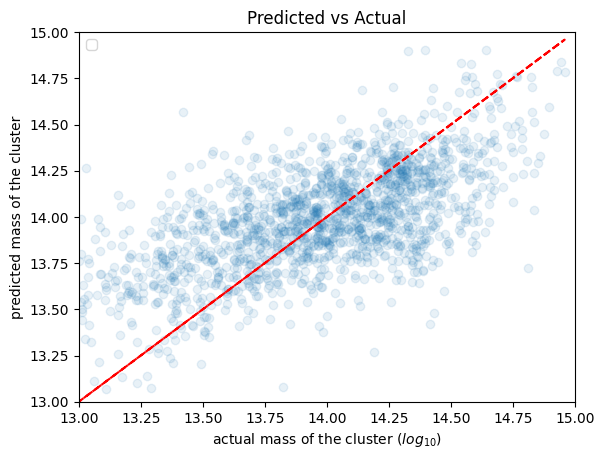

In [8]:
model = regression_model(filters = 10, kernel_size=3, conv_pool_layers = 1, dense_layers = 1) #create the model
early_stopping = EarlyStopping(monitor='val_loss', patience=30, verbose=1, mode='min', restore_best_weights=True)

# Apply data augmentation to the training data
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
])
X_train_augmented = data_augmentation(X_train)

history = model.fit(np.array(X_train), np.array(Y_train), validation_data = (np.array(X_val), np.array(
    Y_val)), epochs=300, callbacks=[early_stopping], batch_size=64, verbose = 1)

val_loss = history.history['val_loss'] #get the validation loss
loss = history.history['loss'] #get the training loss
predictions = model.predict(np.array(X_test)) #get the predictions

# plot the predictions on a scatter plot
plt.title('Predicted vs Actual')
plt.plot(Y_test, Y_test, 'r--')
plt.xlim(13,15)
plt.ylim(13,15)
plt.scatter(Y_test[:], predictions[:], alpha = 0.1)
plt.xlabel('actual mass of the cluster ($log_{10}$)')
plt.ylabel('predicted mass of the cluster')
plt.legend()
plt.savefig('naive_predictions.png', dpi = 300)

#save the model
model.save('naive_model.h5')

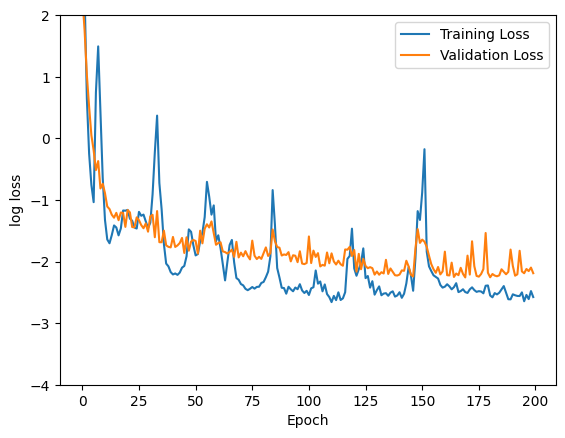

In [9]:
#plot the loss
plt.plot(np.log(loss), label='Training Loss')
plt.plot(np.log(val_loss), label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('log loss')
plt.ylim(-4,2)
plt.legend()
plt.savefig('naive_loss.png')
plt.show()
